In [ ]:

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


np.random.seed(42)
num_samples = 10000


num_tasks = np.random.randint(1, 100, num_samples)
avg_task_size = np.random.uniform(0.1, 10.0, num_samples)
vm_type = np.random.choice([1, 2, 3], num_samples)
num_users = np.random.randint(1, 500, num_samples)
time_of_day = np.random.uniform(0, 24, num_samples)
priority_level = np.random.randint(1, 5, num_samples)


CPU_util = (
    0.6 * (num_tasks / 100)
    + 0.3 * (avg_task_size / 10)
    + 0.1 * (vm_type / 3)
    + np.random.normal(0, 0.05, num_samples)
)
CPU_util = np.clip(CPU_util, 0, 1)

Mem_util = (
    0.4 * (avg_task_size / 10)
    + 0.3 * (num_tasks / 100)
    + 0.2 * (priority_level / 5)
    + np.random.normal(0, 0.05, num_samples)
)
Mem_util = np.clip(Mem_util, 0, 1)

Disk_IO = (
    40 * (avg_task_size / 10)
    + 10 * (priority_level / 5)
    + np.random.normal(0, 2, num_samples)
)
Disk_IO = np.clip(Disk_IO, 0, 100)

Network_bw = (
    20 * (num_users / 500)
    + 10 * (avg_task_size / 10)
    + np.random.normal(0, 1.5, num_samples)
)
Network_bw = np.clip(Network_bw, 0, 100)

In [ ]:
df = pd.DataFrame({
    'num_tasks': num_tasks,
    'avg_task_size_MB': avg_task_size,
    'vm_type': vm_type,
    'num_users': num_users,
    'time_of_day': time_of_day,
    'priority_level': priority_level,
    'CPU_utilization': CPU_util,
    'Memory_usage': Mem_util,
    'Disk_IO_MBps': Disk_IO,
    'Network_bw_MBps': Network_bw
})
print("✅ Sample of Generated Data:")
print(df.head())

✅ Sample of Generated Data:
   num_tasks  avg_task_size_MB  vm_type  num_users  time_of_day  \
0         52          7.053017        3        263    18.816798   
1         93          8.534496        3        373     0.432582   
2         15          3.630428        1         64    14.280740   
3         72          2.687833        3        338    14.120850   
4         61          9.471326        3        320     9.088990   

   priority_level  CPU_utilization  Memory_usage  Disk_IO_MBps  \
0               2         0.668280      0.507903     32.289957   
1               1         0.857297      0.718961     38.032805   
2               1         0.121843      0.243293     15.224252   
3               4         0.577197      0.506313     18.917088   
4               4         0.767491      0.704871     50.024832   

   Network_bw_MBps  
0        16.832846  
1        23.314395  
2         7.950099  
3        17.147626  
4        22.340576  


In [ ]:
df.size


100000

In [ ]:

X = df[['num_tasks', 'avg_task_size_MB', 'vm_type', 'num_users', 'time_of_day', 'priority_level']]
y = df[['CPU_utilization', 'Memory_usage', 'Disk_IO_MBps', 'Network_bw_MBps']]

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)


In [ ]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(4, activation='linear')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


history = model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, validation_split=0.2, verbose=1)


loss, mae = model.evaluate(X_test_scaled, y_test_scaled)
print(f"Test MAE: {mae:.4f}")


y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

pred_df = pd.DataFrame(y_pred, columns=['CPU_pred', 'Mem_pred', 'Disk_pred', 'Net_pred'])
print(" Sample Predictions:")
print(pred_df.head())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,364 (44.39 KB)

 Trainable params: 11,364 (44.39 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.4538 - mae: 0.5006 - val_loss: 0.0712 - val_mae: 0.2084
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0890 - mae: 0.2356 - val_loss: 0.0683 - val_mae: 0.2045
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0827 - mae: 0.2255 - val_loss: 0.0660 - val_mae: 0.2007
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0798 - mae: 0.2218 - val_loss: 0.0663 - val_mae: 0.2015
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0762 - mae: 0.2176 - val_loss: 0.0668 - val_mae: 0.2017
Epoch 6/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0786 - mae: 0.2193 - val_loss: 0.0660 - val_mae: 0.2015
Epoch 7/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0752 - mae: 0.2156 - val_loss: 0.0652 - val_mae: 0.1996
Epoch 8/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0770 - mae: 0.2178 - val_loss: 0.0657 - val_mae: 0.2000
Epoch 9/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - l

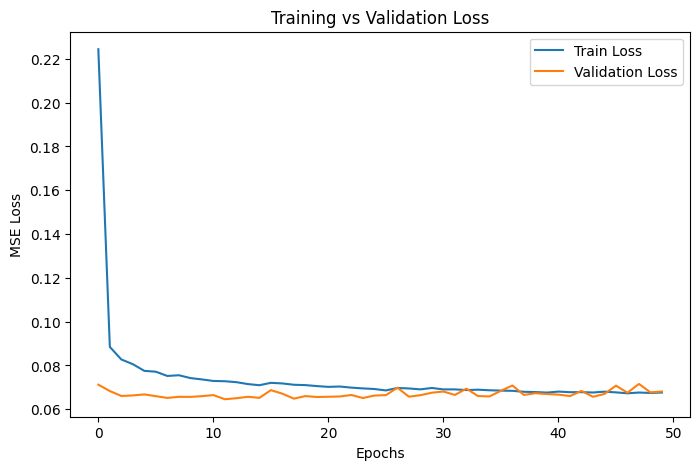

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

In [ ]:

sample_input = np.array([[45, 5.2, 2, 250, 14, 3]])  # [tasks, avg_size, vm_type, users, time, priority]
scaled_input = scaler_X.transform(sample_input)
prediction_scaled = model.predict(scaled_input)
prediction = scaler_y.inverse_transform(prediction_scaled)

print("\n Predicted Resource Utilization for Input:")
print(f"CPU Utilization: {prediction[0][0]*100:.2f}%")
print(f"Memory Usage: {prediction[0][1]*100:.2f}%")
print(f"Disk I/O: {prediction[0][2]:.2f} MB/s")
print(f"Network Bandwidth: {prediction[0][3]:.2f} MB/s")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step

 Predicted Resource Utilization for Input:
CPU Utilization: 49.52%
Memory Usage: 46.16%
Disk I/O: 26.03 MB/s
Network Bandwidth: 14.56 MB/s


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
model.save('resource_prediction_model.h5')
print("✅ Model saved successfully as pickle file!")

✅ Model saved successfully as pickle file!


# Task
Create a Flask API to serve the saved model for prediction.

## Install flask and gunicorn

### Subtask:
Install the necessary libraries for creating and serving the Flask application.


**Reasoning**:
The subtask is to install the necessary libraries for creating and serving the Flask application. This requires using pip to install 'flask' and 'gunicorn'.



In [ ]:
%pip install flask gunicorn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 2.9 MB/s eta 0:00:00


## Load the model and scalers

### Subtask:
Load the trained model and the fitted scalers from the saved files.


**Reasoning**:
Load the saved Keras model and the fitted scalers from the files.



**Reasoning**:
The previous command failed because 'mse' is not recognized as a custom object when loading the model. I need to include 'mse' as a custom object when loading the model.



**Reasoning**:
The previous command failed because the scaler files were not saved. I need to save the scaler objects as pickle files before attempting to load them.



In [ ]:
import pickle

with open('scaler_X.pkl', 'wb') as f:
    pickle.dump(scaler_X, f)

with open('scaler_y.pkl', 'wb') as f:
    pickle.dump(scaler_y, f)

print("✅ Scalers saved successfully as pickle files!")

✅ Scalers saved successfully as pickle files!


**Reasoning**:
Now that the scalers are saved, I can load the trained model and the fitted scalers from the saved files as per the subtask instructions.



In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import MeanSquaredError
import pickle

model = load_model('resource_prediction_model.h5', custom_objects={'mse': MeanSquaredError})

with open('scaler_X.pkl', 'rb') as f:
    scaler_X = pickle.load(f)

with open('scaler_y.pkl', 'rb') as f:
    scaler_y = pickle.load(f)

print("✅ Model and scalers loaded successfully!")

✅ Model and scalers loaded successfully!


## Define the flask application

### Subtask:
Create a Flask app instance.


**Reasoning**:
Create a Flask app instance to prepare for building the API.



In [ ]:
from flask import Flask

app = Flask(__name__)

## Define the prediction endpoint

### Subtask:
Create a route that accepts input data, preprocesses it using the loaded scaler, makes a prediction using the loaded model, inverse transforms the prediction using the loaded scaler, and returns the result as JSON.


**Reasoning**:
Define the Flask route for prediction, preprocess the input, make a prediction, inverse transform the prediction, and return the result as JSON.



In [ ]:
from flask import request, jsonify
import numpy as np

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json(force=True)
    # Assuming the input data is a list of features in the correct order
    input_data = np.array([data['features']]) # Wrap in list to handle single prediction


    scaled_input = scaler_X.transform(input_data)
    prediction_scaled = model.predict(scaled_input)
    prediction = scaler_y.inverse_transform(prediction_scaled)


    # Assuming prediction returns a single sample result
    prediction_result = {
        'CPU_utilization': float(prediction[0][0]),
        'Memory_usage': float(prediction[0][1]),
        'Disk_IO_MBps': float(prediction[0][2]),
        'Network_bw_MBps': float(prediction[0][3])
    }

    return jsonify(prediction_result)

## Run the flask application

### Subtask:
Add code to run the Flask development server.


**Reasoning**:
Add the code to run the Flask development server within a conditional block.



In [ ]:
if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug: * Restarting with watchdog (inotify)
ERROR:root:Unexpected exception finding object shape
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/google/colab/_debugpy_repr.py", line 54, in get_shape
    shape = getattr(obj, 'shape', None)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/werkzeug/local.py", line 318, in __get__
    obj = instance._get_current_object()
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/werkzeug/local.py", line 519, in _get_current_object
    raise RuntimeError(unbound_message) from None
RuntimeError: Working outside of request context.

This typically means that you attempted to use functionality that needed
an active HTTP request. Cons

In [ ]:
data['features']

NameError: name 'data' is not defined